In [1]:
from keras.callbacks import ModelCheckpoint
import numpy as np
from skimage.morphology import disk
from skimage import morphology
import matplotlib.pyplot as plt
from glob import glob
from random import shuffle
%matplotlib inline

from utils import util_seg, util_train
from model_arch import unet

Using TensorFlow backend.
2024-08-14 21:33:39.346129: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2024-08-14 21:33:39.346204: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2024-08-14 21:33:39.346210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
def get_filled_donut_unet(model, npy_x):
    """
    Applies a filled donut segmentation to the input image using a U-Net model.
    Args:
        model (object): The U-Net model used for prediction.
        npy_x (ndarray): The input image.
    Returns:
        ndarray: The segmented image with filled donut regions.
    """

    img_result = np.zeros_like(npy_x)
    pred_unet = model.predict(npy_x[np.newaxis,...,0:1])
    img_unet = morphology.label(pred_unet[0,...,1] > 0.4) #.astype(int)
    img_largest = (util_seg._get_largest_component(img_unet)).astype(int)
    k1 = np.random.randint(3,6)
    k2 = np.random.randint(6,14)
    img_ring = morphology.dilation(img_largest,disk(k2)) - morphology.erosion(img_largest,disk(k1))
    img_result[...,0] = morphology.erosion(img_largest,disk(k1)).astype(int)
    img_result[...,1] = img_ring.astype(int)
    img_result[...,2] = img_result[...,0] + img_result[...,1]
    return img_result

## Load model to re-train the unet
- labels using morphological operations will be generated online inside the DataGenerator. 

In [3]:
HEIGHT = 256
WIDTH = 256

model = unet.get_unet(HEIGHT, WIDTH, img_ch=1, ch=3)

2024-08-14 21:33:40.788932: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-14 21:33:40.788964: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-14 21:33:40.788982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-13-133.us-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2024-08-14 21:33:40.789136: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-08-14 21:33:40.795625: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2024-08-14 21:33:40.795882: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b0c409b440 initialized for platform Ho

## DataGenerator

In [4]:
filenames = [filepath.split('/')[-1] for filepath in glob('example_data/SAX/sax_images/*.npy')]
shuffle(filenames)
X_train = filenames[:int(len(filenames)*0.8)]
X_val = filenames[int(len(filenames)*0.8):]

size_of_training = len(X_train)
size_of_validation = len(X_val)

print('Size of training: ', size_of_training)
print('Size of validation: ', size_of_validation)

Size of training:  8
Size of validation:  2


In [5]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 64
N_CHANNELS = 3

## Load Data Generator

In [6]:
# construct the training image generator for data augmentation

train_DataGenerator = util_train.DataGenerator(
    list_IDs=X_train,
    labels=X_train,
    path_img='example_data/SAX/sax_images/',
    path_label='example_data/SAX/sax_filled_hed_labels/',
    path_self_learning='example_data/SAX/sax_filled_donut_unet/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    augment=False,
    model=None,
    saxmid=True,
    saxunet=True
    )

val_DataGenerator = util_train.DataGenerator(
    list_IDs=X_val,
    labels=X_val,
    path_img='example_data/SAX/sax_images/',
    path_label='example_data/SAX/sax_filled_hed_labels/',
    path_self_learning='example_data/SAX/sax_filled_donut_unet/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    augment=False,
    model=None,
    saxmid=True,
    saxunet=True
    )

## Visualize images and labels loaded by the datagenerator

(64, 256, 256, 3) (64, 256, 256, 3) 1.0 1.0
13500.0


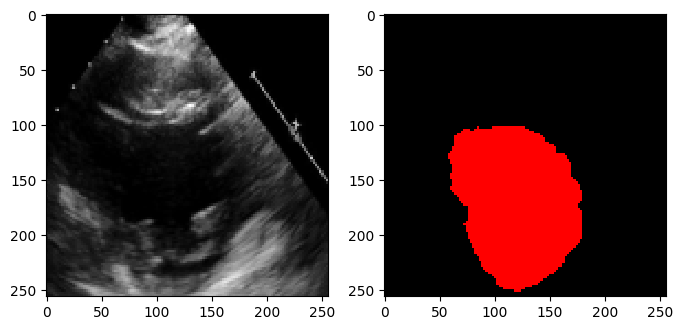

7720.0


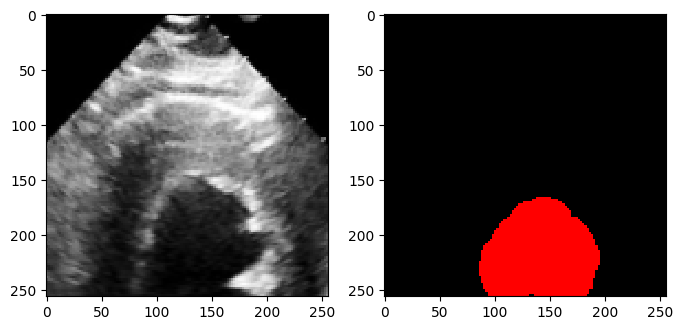

4120.0


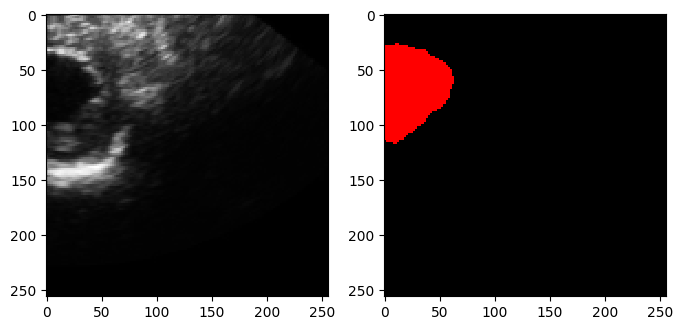

7216.0


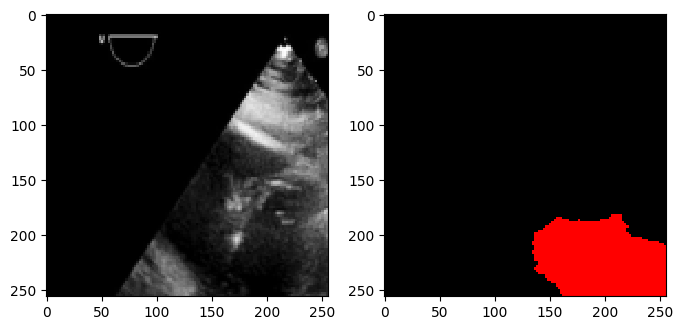

2150.0


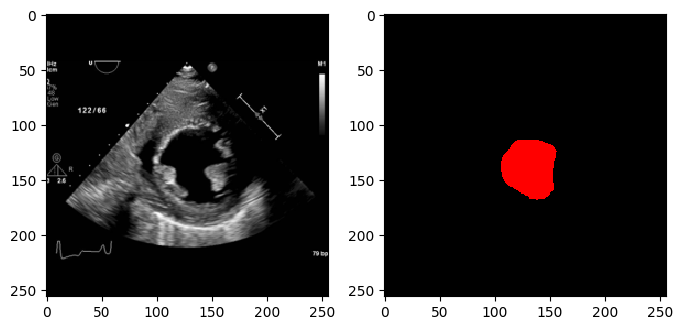

1971.0


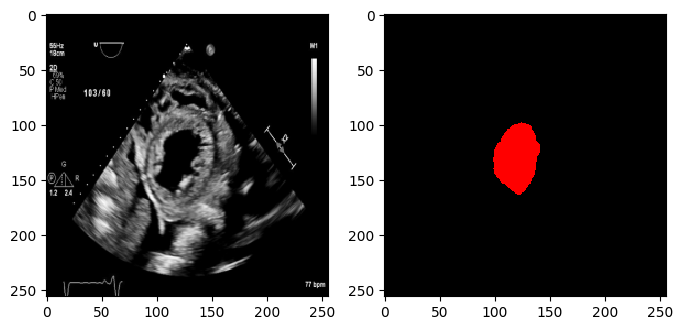

3083.0


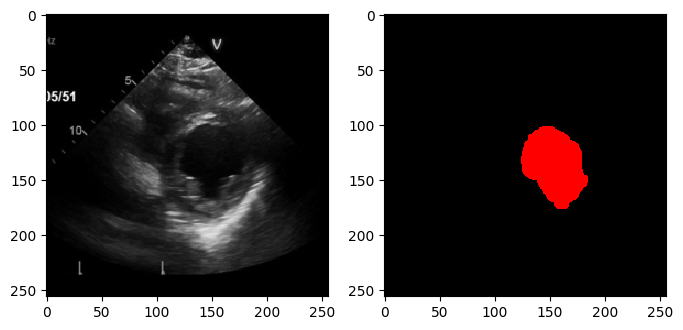

2301.0


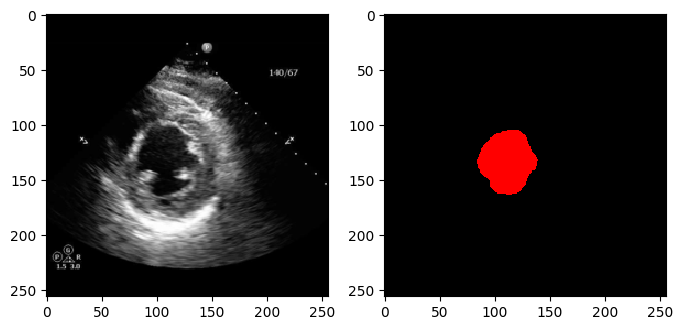

In [7]:
x, y =train_DataGenerator.__getitem__(0)
print(x.shape,y.shape,x.max(),y.max())
   
for k in range(8):
    print(y[k].sum())
    plt.figure(figsize=[8,8])
    plt.subplot(121),plt.imshow(x[k][...,0], cmap='gray')
    plt.subplot(122),plt.imshow((y[k][...]), cmap = 'gray')
    plt.show()

In [8]:
path_w = 'example_model_checkpoints/SAX/step3_unet_filled_donut_pred_unet_{epoch:02d}.h5'

LossHist = util_train.LossHistory()
checkpoint = ModelCheckpoint(path_w, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

EPOCHS = 5

hist = model.fit_generator(generator = train_DataGenerator,
                           verbose=0,   # We have to disable prog bar because our validation set is so small, but you can remove this line when using more data to see training progress
                           steps_per_epoch = size_of_training//BATCH_SIZE,
                           validation_data = val_DataGenerator,
                           callbacks=[LossHist,checkpoint],
                           use_multiprocessing = False, 
                           validation_steps = max(1,size_of_validation//BATCH_SIZE), 
                           epochs=EPOCHS, shuffle=True)

/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


In [9]:
model.save('example_models/SAX/step3_unet_filled_donut_pred_unet.h5')

In [10]:
# Because the sax unet model that we just trained was trained on very little data, we use pre-generated labels for self training in this example

# Generate the self learning labels

# path_img = 'example_data/SAX/sax_images/'
# path_label = 'example_data/SAX/sax_filled_donut_unet/'
# for ID in filenames:
#     npy_X = np.load(f'{path_img}{ID}')            
#     npy_X = cv2.resize(npy_X, (256, 256), interpolation = cv2.INTER_AREA)
#     npy_X = (npy_X - npy_X.min()) / (npy_X.max() - npy_X.min())
#     npy_y = get_filled_donut_unet(model, npy_X)

#     try:
#         np.save(f'{path_label}{ID}', npy_y)
#     except:
#         continue

In [11]:
# construct the training image generator for data augmentation

train_DataGenerator = util_train.DataGenerator(
    list_IDs=X_train,
    labels=X_train,
    path_img='example_data/SAX/sax_images/',
    path_label='example_data/SAX/sax_filled_hed_labels/',
    path_self_learning='example_data/SAX/sax_filled_donut_unet/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    augment=False,
    model=None,
    saxmid=True,
    saxunet=True,
    self_learning=True
    )

val_DataGenerator = util_train.DataGenerator(
    list_IDs=X_val,
    labels=X_val,
    path_img='example_data/SAX/sax_images/',
    path_label='example_data/SAX/sax_filled_hed_labels/',
    path_self_learning='example_data/SAX/sax_filled_donut_unet/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    augment=False,
    model=None,
    saxmid=True,
    saxunet=True,
    self_learning=True
    )

(64, 256, 256, 3) (64, 256, 256, 3) 1.0 1.0
18568.0


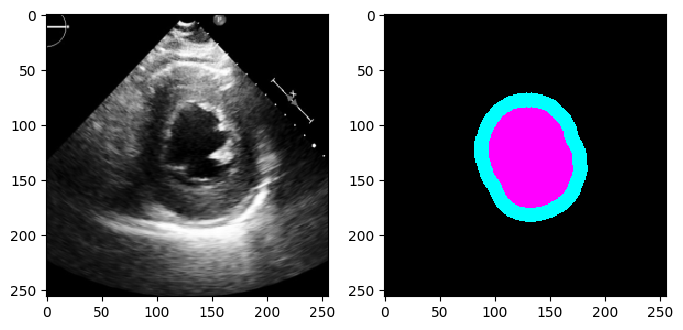

8734.0


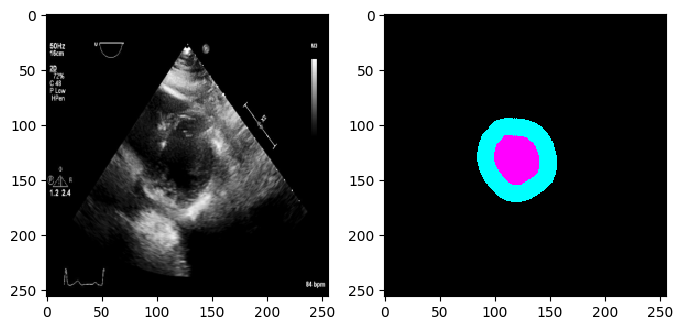

35392.0


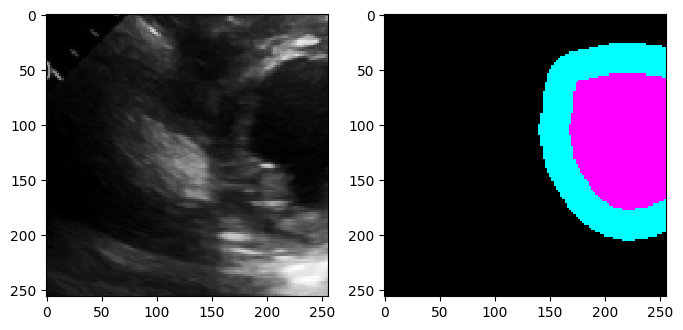

34032.0


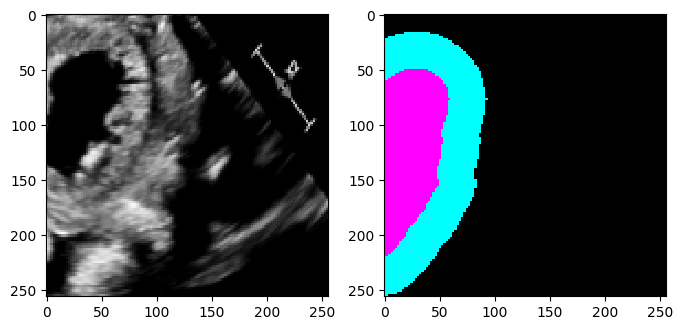

37088.0


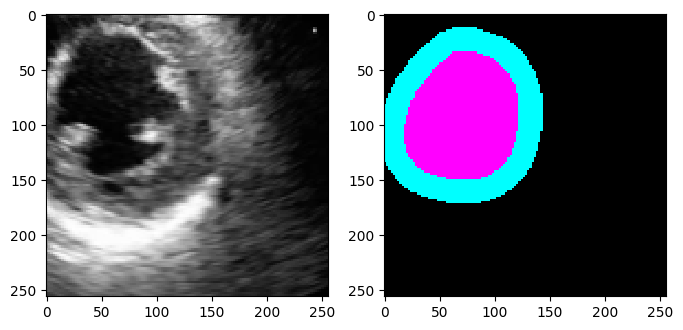

31952.0


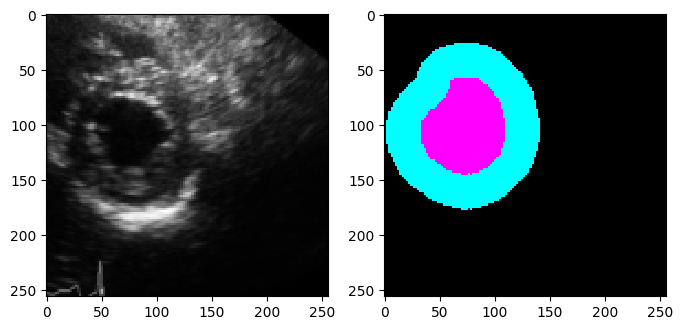

39800.0


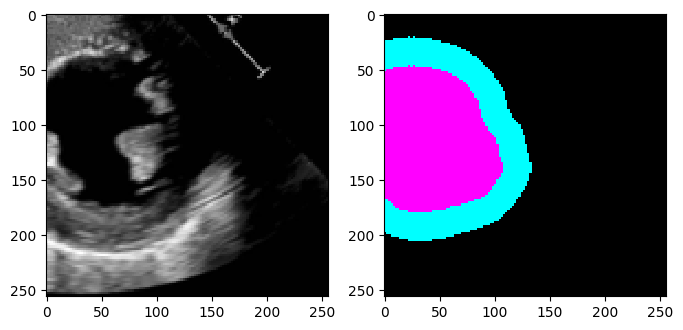

33344.0


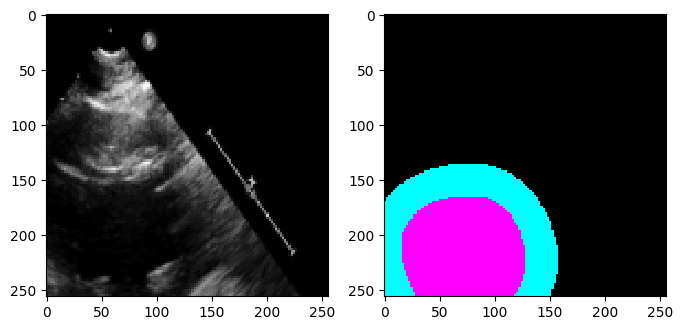

In [12]:
x, y = train_DataGenerator.__getitem__(0)
print(x.shape,y.shape,x.max(),y.max())
   
for k in range(8):
    print(y[k].sum())
    plt.figure(figsize=[8,8])
    plt.subplot(121),plt.imshow(x[k][...,0], cmap='gray')
    plt.subplot(122),plt.imshow((y[k][...]), cmap = 'gray')
    plt.show()

In [13]:
path_w = 'example_model_checkpoints/SAX/step4_unet_label_endocardial_epicardial_seg_{epoch:02d}.h5'

LossHist = util_train.LossHistory()
checkpoint = ModelCheckpoint(path_w, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

EPOCHS = 10

hist = model.fit_generator(generator = train_DataGenerator,
                           verbose=0,   # We have to disable prog bar because our validation set is so small, but you can remove this line when using more data to see training progress
                           steps_per_epoch = size_of_training//BATCH_SIZE,
                           validation_data = val_DataGenerator,
                           callbacks=[LossHist,checkpoint],
                           use_multiprocessing = False, 
                           validation_steps = max(1,size_of_validation//BATCH_SIZE), 
                           epochs=EPOCHS, shuffle=True)

In [14]:
model.save('example_models/SAX/step4_unet_label_endocardial_epicardial_seg.h5')